# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

**Write your answer in this cell.**
It requires fewer parameters than traditional convolutional networks, as there is no need to relearn redundant feature-maps.Traditional feed-forward architectures can be viewed as algorithms with a state, which is passed on from layer to layer. Each layer reads the state from its preceding layer and writes to the subsequent layer. It changes the state but also passes on information that needs to be preserved.
DenseNet architecture explicitly differentiates between information that is added to the network and information that is preserved. DenseNet layers are very narrow adding only a small set of feature-maps to the "collective knowledge" of the network and keep the remaining feature-maps unchanged and the final classifier makes a decision based on all feature-maps in the network.
Besides better parameter efficiency, one big advantage of DenseNets is their improved flow of information and gradients throughout the network, which makes them easy to train. Each layer has direct access to the gradients from the loss function and the original input signal, leading to an implicit deep supervision.  This helps training of deeper network architectures. Further,that dense connections have a regularizing effect, which reduces over-fitting on tasks with smaller training set sizes.

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [79]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


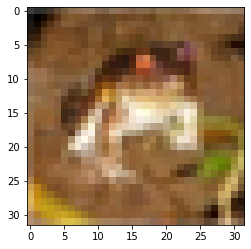

In [74]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

---
## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-121 and DenseNet-169 as depicted in the original paper.

In [80]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model

In [ ]:
import os
# 指定使用0,1,2三块卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

In [ ]:
# dense块内卷积小块
def conv_block(conv_input, nb_channels, dropout_rate=None, weight_decay=1e-4):
    
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(conv_input)
    x = Activation('relu')(x)
    x = Conv2D(nb_channels * 4, (1, 1), kernel_initializer='he_normal', padding='same',
               kernel_regularizer=l2(weight_decay))(x)
    
    if dropout_rate is not None:
        x = Dropout(dropout_rate)(x)
        
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_channels, (3, 3), kernel_initializer='he_normal', padding='same',
               kernel_regularizer=l2(weight_decay))(x)
    
    if dropout_rate is not None:
        x = Dropout(dropout_rate)(x)
    
    x = Concatenate()([conv_input, x])
    
    return x

In [ ]:
# dense块
def dense_block(conv_input, nb_block, nb_channels, growth_rate, dropout_rate=None, weight_decay=1e-4):
    
    x = conv_input
    for _ in range(nb_block):
        x = conv_block(x, growth_rate, dropout_rate, weight_decay)
        nb_channels += growth_rate
        
    return x,nb_channels

In [ ]:
# 过渡层 
def transition_block(conv_input, nb_channels, compression, dropout_rate=None, weight_decay=1e-4):
    
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(conv_input)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_channels * compression), (1, 1), kernel_initializer='he_normal', padding='same',
               kernel_regularizer=l2(weight_decay))(x)
    # Adding dropout
    if dropout_rate is not None:
        x = Dropout(dropout_rate)(x)
        
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    
    return x

In [ ]:
def DenseNet(densenet_input, blocks, num_classes, nb_channels, growth_rate, compression, dropout_rate=None):
    
    concat_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
#     x = Conv2D(nb_channels * 2, (7,7), kernel_initializer='he_normal', padding='same', strides=2)(densenet_input)
    x = Conv2D(nb_channels * 2, (3,3), kernel_initializer='he_normal', padding='same', strides=1)(densenet_input)
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    x = Activation('relu')(x)
#     x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    x = Concatenate()([densenet_input, x])
    
    for idx,block in enumerate(blocks):
        x,nb_channels = dense_block(x, block, nb_channels, growth_rate, dropout_rate)
        
        if idx!=len(blocks)-1:
            x = transition_block(x, nb_channels, compression, dropout_rate)
    
        nb_channels = int(nb_channels * compression)
        
    x = BatchNormalization(axis=concat_axis, epsilon=1.1e-5)(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
#     x = Flatten()(x)
    x = Dense(num_classes, kernel_initializer='he_normal', activation='softmax')(x)
    
    return x

In [ ]:
# implement the code of your DenseNet-121 model here.
def DenseNet_121(densenet_input, num_classes, nb_channels, growth_rate, compression=0.5, dropout_rate=None):
    blocks = [6, 12, 24, 16]
    return DenseNet(densenet_input, blocks, num_classes, nb_channels, growth_rate, compression, dropout_rate)

In [ ]:
# implement the code of your DenseNet-169 model here.
def DenseNet_169(densenet_input, num_classes, nb_channels, growth_rate, compression=0.5, dropout_rate=None):
    blocks = [6, 12, 32, 32]
    return DenseNet(densenet_input, blocks, num_classes, nb_channels, growth_rate, compression, dropout_rate)

---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

###### model_121 self_design

In [ ]:
# implement your code here.
inputs = Input(x_train[0].shape)
outputs = DenseNet_121(inputs, num_classes, nb_channels=32, growth_rate=12, compression=0.5)
model_121 = Model(inputs, outputs, name="densenet")
# model_121.summary()
model_121.compile(
    optimizer=RMSprop(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# 训练模型
history_121 = model_121.fit(x_train, y_train, validation_split=0.1, batch_size=256, epochs=300)

In [ ]:
model_121.save('./densenet121_selfbuild_up.h5')

###### model_169 self_design

In [ ]:
inputs = Input(x_train[0].shape)
outputs = DenseNet_169(inputs, num_classes, nb_channels=32, growth_rate=12, compression=0.5)
model_169 = Model(inputs, outputs, name="densenet")
# model_169.summary()
model_169.compile(
    optimizer=RMSprop(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# 训练模型
history_169 = model_169.fit(x_train, y_train, validation_split=0.1, batch_size=256, epochs=300)

In [ ]:
model_169.save('./densenet169_selfbuild_up.h5')

### 4.2 Test your models. (5 marks)

In [ ]:
# implement your code here.

###### DenseNet121 self_design

In [ ]:
# evaluate

In [81]:
model_121 = load_model('./densenet121_selfbuild.h5')

In [82]:
scores_121 = model_121.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores_121[0])
print('Test accuracy:', scores_121[1])

313/313 [==============================] - 109s 347ms/step - loss: 1.1149 - accuracy: 0.8328
Test loss: 1.1149160861968994
Test accuracy: 0.8327999711036682


###### DenseNet_169 self_design

In [83]:
# evaluate

In [84]:
model_169 = load_model('./densenet169_selfbuild.h5')

In [85]:
scores_169 = model_169.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores_169[0])
print('Test accuracy:', scores_169[1])

313/313 [==============================] - 128s 408ms/step - loss: 1.6051 - accuracy: 0.7681
Test loss: 1.6050864458084106
Test accuracy: 0.7681000232696533


---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

###### DenseNet121 Keras 

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
# implement your code here.
base_model_121 = DenseNet121(
    include_top=False, weights='imagenet',  input_shape=x_train[0].shape
)

x = base_model_121.output
x = GlobalAveragePooling2D()(x) 
# x = Flatten()(x)
# x = Dropout(0.5)(x)
predictions_121_tf = Dense(num_classes, kernel_initializer='he_normal', activation='softmax', name='last_output')(x)
model_121_tf = Model(inputs=base_model_121.input, outputs=predictions_121_tf)

# model_121_tf.summary()

In [ ]:
model_121_tf.compile(
    optimizer=RMSprop(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# 训练模型
history_121_tf = model_121_tf.fit(x_train, y_train, validation_split=0.1, batch_size=512, epochs=100)

In [ ]:
# 保存模型
model_121_tf.save('./densenet121_tensorflow_up.h5')

###### DenseNet121 Keras evaluate

In [88]:
model_121_tf = load_model('./densenet121_tensorflow.h5')

In [89]:
scores_121_tf = model_121_tf.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores_121_tf[0])
print('Test accuracy:', scores_121_tf[1])

313/313 [==============================] - 26s 82ms/step - loss: 1.3960 - accuracy: 0.8233
Test loss: 1.396020770072937
Test accuracy: 0.8233000040054321


###### DenseNet169 Keras 

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
# implement your code here.
base_model_169 = DenseNet169(
    include_top=False, weights='imagenet',  input_shape=x_train[0].shape
)

x = base_model_169.output
x = GlobalAveragePooling2D()(x) 
# x = Flatten()(x)
# x = Dropout(0.5)(x)
predictions_169_tf = Dense(num_classes, kernel_initializer='he_normal', activation='softmax', name='last_output')(x)
model_169_tf = Model(inputs=base_model_169.input, outputs=predictions_169_tf)

# model_169_tf.summary()

In [ ]:
model_169_tf.compile(
    optimizer=RMSprop(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# 训练模型
history_169_tf = model_169_tf.fit(x_train, y_train, validation_split=0.1, batch_size=512, epochs=100)

In [ ]:
# 保存模型
model_169_tf.save('./densenet169_tensorflow_up.h5')

###### DenseNet169 Keras evaluate

In [86]:
model_169_tf = load_model('./densenet169_tensorflow.h5')

In [87]:
scores_169_tf = model_169_tf.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores_169_tf[0])
print('Test accuracy:', scores_169_tf[1])

313/313 [==============================] - 32s 101ms/step - loss: 1.3709 - accuracy: 0.8361
Test loss: 1.3708518743515015
Test accuracy: 0.8360999822616577


---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-169 better than DenseNet-121? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer:No, the input images's shape is (32,32,3), which means it may not conclude so many features can be extracted, so increasing the depth may not be so useful in these experiments. In fact, I had tried more shallow models to predict, and the performance is not much worse than the deep model. Besides, I think DenseNet169 needs more epoch to train, but I don't have such enough time to train it.

2. Compare the results of your implementation with the pre-trained models from Keras. (10 marks)

Answer:My implementation is worse than the tensorflow's. Because the tensorflow'DenseNet uses the imagenet dataset to pre-train it's model, which means the more datas and the more features can be extracted.

-----------------------------------
Besides, the tensorflow'DenseNet model was designed to train the images of the shape (224,224,3), so it uses the Convolution layer of the 7 * 7 kernal to deal the input data at the begining. But our images'shape is (32,32,3), the big size kernal may lose some small features, so i use the 3 * 3 kernal to replace the 7 * 7 kernal and set the strides to 1. Besides, I removed the first MaxPooling2D layer for the similar reason I said before.

